## week0_09 practice: PyTorch practice, hints and Dataloaders

Credits:
* First part is based on YSDA [Practical RL course week04 materials](https://github.com/yandexdataschool/Practical_RL/tree/master/week04_%5Brecap%5D_deep_learning).
* Second part is based on PyTorch official tutorials and [this kaggle kernel](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader)
* Third part is based on PyTorch tutorial by [Stanford CS 231n course](http://cs231n.stanford.edu)

![img](https://pytorch.org/tutorials/_static/pytorch-logo-dark.svg)

__This notebook__ will remind you how to use pytorch low and high-level core. You can install it [here](http://pytorch.org/).

__Pytorch feels__ differently than other frameworks (like tensorflow/theano) on almost every level. TensorFlow makes your code live in two "worlds" simultaneously:  symbolic graphs and actual tensors. First you declare a symbolic "recipe" of how to get from inputs to outputs, then feed it with actual minibatches of data.  In pytorch, __there's only one world__: all tensors have a numeric value.

You compute outputs on the fly without pre-declaring anything. The code looks exactly as in pure numpy with one exception: pytorch computes gradients for you. And can run stuff on GPU. And has a number of pre-implemented building blocks for your neural nets. [And a few more things.](https://medium.com/towards-data-science/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b)

Let's dive into it!

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import transforms

### Task 1: Tensormancy

__1.1 The [_disclaimer_](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)__

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (6 \cdot \theta) ) \cdot (1 + 0.01 \cdot cos(24 \cdot \theta)) \cdot (0.5 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (10 + sin(10 \cdot \theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

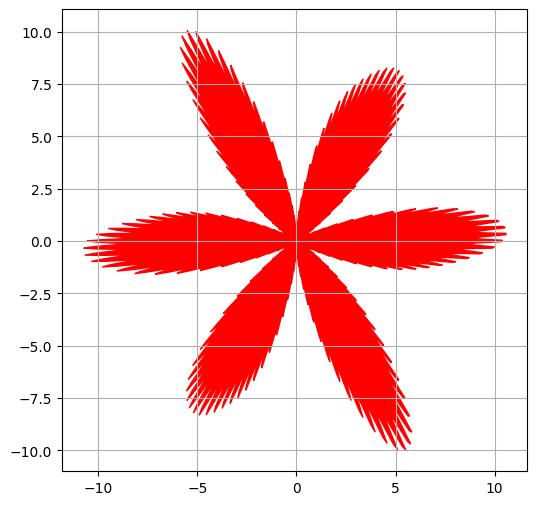

In [2]:
# Создание 1000 равномерно распределённых значений угла
theta = torch.linspace(-np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = (1 + 0.9 * torch.cos(6 * theta)) * (1 + 0.01 * torch.cos(24 * theta)) * (0.5 + 0.05 * torch.cos(200 * theta)) * (10 + torch.sin(10 * theta))

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = rho * torch.cos(theta)
y = rho * torch.sin(theta)


plt.figure(figsize=(6, 6))
plt.fill(x.numpy(), y.numpy(), color='red')
plt.grid()

### Task 2: Using the Dataloader

In [3]:
from torch import nn
from torch.nn import functional as F

In [10]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/week0_08_dropout_batchnorm/notmnist.py -nc

--2025-02-15 18:02:50--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/week0_08_dropout_batchnorm/notmnist.py
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-02-15 18:02:51 ERROR 404: Not Found.



In [4]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist()

Extracting ...
Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done
Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [5]:
class DatasetMNIST(Dataset):
    def __init__(self, path='./notMNIST_small', letters='ABCDEFGHIJ', transform=None):
        self.data, self.labels, _ ,_  = load_notmnist(path=path, letters=letters, test_size=0)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image = self.data[index].transpose(1, 2, 0)
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [6]:
full_dataset = DatasetMNIST('./notMNIST_small', 'AB', transform=None)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [7]:
# we can access and get data with index by __getitem__(index)
img, lab = full_dataset.__getitem__(0)

print(img.shape)
print(type(img))

(28, 28, 1)
<class 'numpy.ndarray'>


In [8]:
a = torchvision.transforms.ToTensor()

a(img).shape

torch.Size([1, 28, 28])

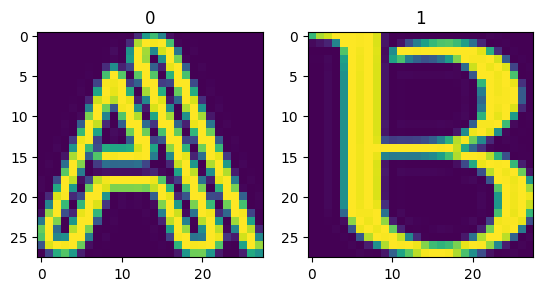

In [12]:
inds = np.random.randint(len(full_dataset), size=2)

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(full_dataset[inds[i]][0].reshape([28,28]))
    plt.title(str(full_dataset[inds[i]][1]))

#### To the DataLoader

In [13]:
train_loader = DataLoader(full_dataset, batch_size=8, shuffle=True)

We can use dataloader as iterator by using iter() function.

In [14]:
train_iter = iter(train_loader)
print(type(train_iter))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>


We can look at images and labels of batch size by extracting data `.next()` method.

In [15]:
images, labels = next(train_iter)

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

images shape on batch size = torch.Size([8, 28, 28, 1])
labels shape on batch size = torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.95612615..1.2348979].


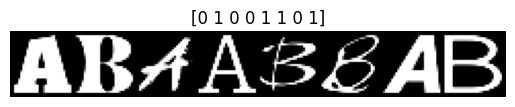

In [16]:
# make grid takes tensor as arg
# tensor : (batchsize, channels, height, width)
grid = torchvision.utils.make_grid(images.permute([0, 3, 1, 2]))

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

And now with transformations:

In [17]:
train_dataset_with_transform = DatasetMNIST(
    transform=torchvision.transforms.ToTensor()
)

Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [18]:
img, lab = train_dataset_with_transform[0]

print('image shape at the first row : {}'.format(img.size()))

image shape at the first row : torch.Size([1, 28, 28])


In [19]:
train_loader_tr = DataLoader(train_dataset_with_transform, batch_size=8, shuffle=True)

train_iter_tr = iter(train_loader_tr)
print(type(train_iter_tr))

images, labels = next(train_iter_tr)

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([8, 1, 28, 28])
labels shape on batch size = torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9274821..1.2529625].


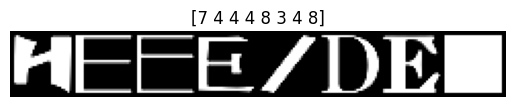

In [20]:
grid = torchvision.utils.make_grid(images)

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

### Composing several transformations

If you want to take data augmentation, you have to make List using `torchvision.transforms.Compose`

```
class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string
```


this function can convert some image by order within `__call__` method.

In [21]:
class Flatten():
    def __call__(self, pic):
        return pic.flatten()

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [22]:
a = Flatten()

In [23]:
a(img).shape

torch.Size([784])

In [24]:
new_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    Flatten()
])

# Putting all together

In [25]:
import time

from IPython.display import clear_output

In [26]:
# use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [27]:
def subset_ind(dataset, ratio: float):
    return np.random.choice(len(dataset), size=int(ratio*len(dataset)), replace=False)

In [28]:
dataset = DatasetMNIST(
    './notMNIST_small',
#     'AB',
    transform=new_transform
)

shrink_inds = subset_ind(dataset, 0.9)
dataset = Subset(dataset, shrink_inds)

print(f'\n\n dataset size: {len(dataset)}, labels: {np.unique(dataset.dataset.labels)}')

Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


 dataset size: 16851, labels: [0 1 2 3 4 5 6 7 8 9]


In [29]:
val_size = 0.2
val_inds = subset_ind(dataset, val_size)

train_dataset = Subset(dataset, [i for i in range(len(dataset)) if i not in val_inds])
val_dataset = Subset(dataset, val_inds)

print(f'  training size: {len(train_dataset)}\nvalidation size: {len(val_dataset)}')

  training size: 13481
validation size: 3370


In [30]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [31]:
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = next(train_iter)

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([32, 784])
labels shape on batch size = torch.Size([32])


In [32]:
loss_func = nn.CrossEntropyLoss()

In [33]:
# create network again just in case
simple_model = nn.Sequential(
    nn.Linear(784, 10),
    nn.Sigmoid(),
)
simple_model.to(device, torch.float32)

opt = torch.optim.Adam(simple_model.parameters(), lr=1e-3)

In [34]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []

    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()

            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                # compute predictions
                y_pred = model(X_batch)  # Forward pass
                loss = loss_fn(y_pred, y_batch)  # Compute loss
                ep_val_loss.append(loss.item())  # Store validation loss

                correct_preds = (y_pred.argmax(dim=1) == y_batch).sum().item()
                accuracy = correct_preds / y_batch.size(0)  # Batch accuracy
                ep_val_accuracy.append(accuracy)  # Store accuracy

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [35]:
n_epochs = 30

simple_train_loss, simple_val_loss, simple_val_accuracy = train_model(simple_model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.186s
	  training loss: 1.709653
	validation loss: 1.649755
	validation accuracy: 0.857
Epoch 2 of 30 took 0.193s
	  training loss: 1.628823
	validation loss: 1.628544
	validation accuracy: 0.861
Epoch 3 of 30 took 0.216s
	  training loss: 1.612879
	validation loss: 1.621274
	validation accuracy: 0.862
Epoch 4 of 30 took 0.183s
	  training loss: 1.604090
	validation loss: 1.614676
	validation accuracy: 0.867
Epoch 5 of 30 took 0.187s
	  training loss: 1.597640
	validation loss: 1.613096
	validation accuracy: 0.864
Epoch 6 of 30 took 0.182s
	  training loss: 1.592721
	validation loss: 1.609230
	validation accuracy: 0.863
Epoch 7 of 30 took 0.186s
	  training loss: 1.588873
	validation loss: 1.610447
	validation accuracy: 0.859
Epoch 8 of 30 took 0.181s
	  training loss: 1.585630
	validation loss: 1.606453
	validation accuracy: 0.868
Epoch 9 of 30 took 0.182s
	  training loss: 1.582624
	validation loss: 1.604982
	validation accuracy: 0.861
Epoch 10 of 30 took 0.183s
	

In [36]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

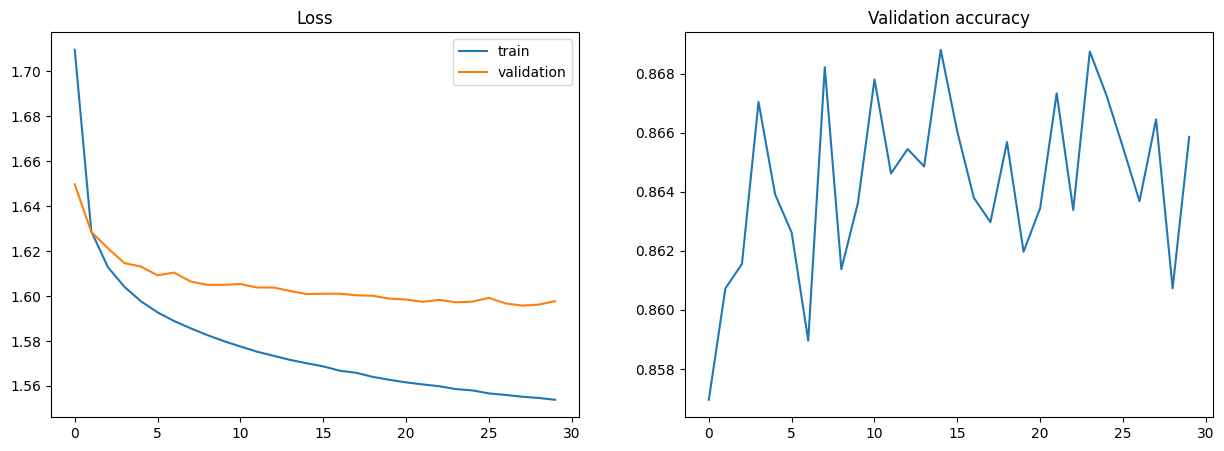

In [37]:
plot_train_process(simple_train_loss, simple_val_loss, simple_val_accuracy)

## Real network

In [38]:
# create network again just in case
real_model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.Sigmoid(),
)
real_model.to(device, torch.float32)

opt = torch.optim.Adam(real_model.parameters(), lr=1e-3)

n_epochs = 30

real_train_loss, real_val_loss, real_val_accuracy = train_model(real_model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.440s
	  training loss: 1.601068
	validation loss: 1.570563
	validation accuracy: 0.883
Epoch 2 of 30 took 0.443s
	  training loss: 1.552774
	validation loss: 1.560886
	validation accuracy: 0.886
Epoch 3 of 30 took 0.420s
	  training loss: 1.540361
	validation loss: 1.556645
	validation accuracy: 0.891
Epoch 4 of 30 took 0.472s
	  training loss: 1.535572
	validation loss: 1.558516
	validation accuracy: 0.891
Epoch 5 of 30 took 0.438s
	  training loss: 1.531504
	validation loss: 1.548815
	validation accuracy: 0.903
Epoch 6 of 30 took 0.461s
	  training loss: 1.530051
	validation loss: 1.564166
	validation accuracy: 0.883
Epoch 7 of 30 took 0.441s
	  training loss: 1.526042
	validation loss: 1.551234
	validation accuracy: 0.899
Epoch 8 of 30 took 0.495s
	  training loss: 1.523723
	validation loss: 1.555200
	validation accuracy: 0.890
Epoch 9 of 30 took 0.534s
	  training loss: 1.521680
	validation loss: 1.551974
	validation accuracy: 0.899
Epoch 10 of 30 took 0.561s
	

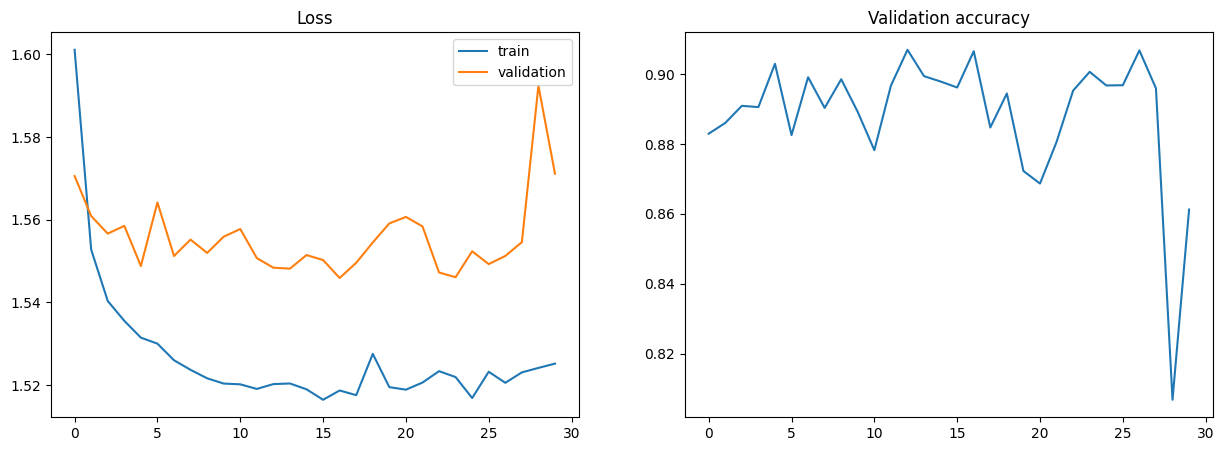

In [39]:
plot_train_process(real_train_loss, real_val_loss, real_val_accuracy)

## Your turn
Try to add some additional transformations (e.g. random crop, rotation etc.) and train your model!

In [40]:
new_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((28, 28)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    Flatten()
])

device = torch.device("cpu")

dataset = DatasetMNIST(
    './notMNIST_small',
#     'AB',
    transform=new_transform
)

shrink_inds = subset_ind(dataset, 0.9)
dataset = Subset(dataset, shrink_inds)

print(f'\n\n dataset size: {len(dataset)}, labels: {np.unique(dataset.dataset.labels)}')

val_size = 0.2
val_inds = subset_ind(dataset, val_size)

train_dataset = Subset(dataset, [i for i in range(len(dataset)) if i not in val_inds])
val_dataset = Subset(dataset, val_inds)

print(f'  training size: {len(train_dataset)}\nvalidation size: {len(val_dataset)}')

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

train_iter = iter(train_loader)
print(type(train_iter))

images, labels = next(train_iter)

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

loss_func = nn.CrossEntropyLoss()

Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


 dataset size: 16851, labels: [0 1 2 3 4 5 6 7 8 9]
  training size: 13481
validation size: 3370
<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([32, 784])
labels shape on batch size = torch.Size([32])


### Dropout try

Epoch 1 of 30 took 1.817s
	  training loss: 1.949241
	validation loss: 1.809406
	validation accuracy: 0.536
Epoch 2 of 30 took 1.904s
	  training loss: 1.805048
	validation loss: 1.782018
	validation accuracy: 0.544
Epoch 3 of 30 took 2.045s
	  training loss: 1.775375
	validation loss: 1.751624
	validation accuracy: 0.602
Epoch 4 of 30 took 2.005s
	  training loss: 1.768423
	validation loss: 1.761030
	validation accuracy: 0.594
Epoch 5 of 30 took 1.969s
	  training loss: 1.759128
	validation loss: 1.768881
	validation accuracy: 0.617
Epoch 6 of 30 took 2.201s
	  training loss: 1.752262
	validation loss: 1.744675
	validation accuracy: 0.634
Epoch 7 of 30 took 2.094s
	  training loss: 1.743868
	validation loss: 1.725987
	validation accuracy: 0.679
Epoch 8 of 30 took 2.062s
	  training loss: 1.739727
	validation loss: 1.727855
	validation accuracy: 0.682
Epoch 9 of 30 took 1.959s
	  training loss: 1.727286
	validation loss: 1.726535
	validation accuracy: 0.684
Epoch 10 of 30 took 1.938s
	

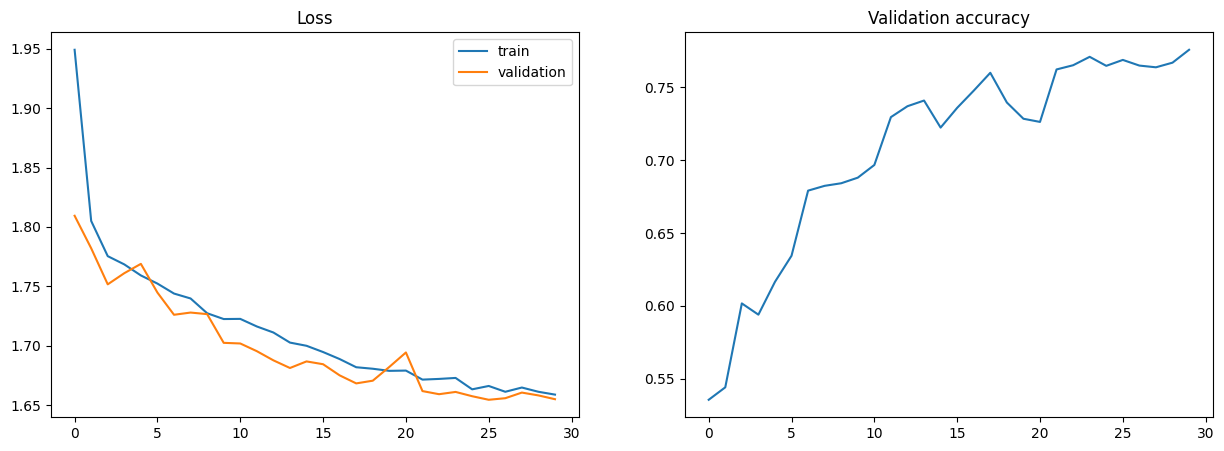

In [41]:
 # create network again just in case
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(200, 10),
    nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 30

train_loss1, val_loss1, val_accuracy1 = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

plot_train_process(train_loss1, val_loss1, val_accuracy1)

### Batchnorm try

Epoch 1 of 30 took 2.026s
	  training loss: 1.965219
	validation loss: 1.889335
	validation accuracy: 0.755
Epoch 2 of 30 took 1.810s
	  training loss: 1.861035
	validation loss: 1.810057
	validation accuracy: 0.787
Epoch 3 of 30 took 1.833s
	  training loss: 1.800296
	validation loss: 1.764285
	validation accuracy: 0.806
Epoch 4 of 30 took 2.010s
	  training loss: 1.759287
	validation loss: 1.723071
	validation accuracy: 0.807
Epoch 5 of 30 took 2.225s
	  training loss: 1.730717
	validation loss: 1.700691
	validation accuracy: 0.831
Epoch 6 of 30 took 2.183s
	  training loss: 1.705580
	validation loss: 1.675344
	validation accuracy: 0.833
Epoch 7 of 30 took 1.917s
	  training loss: 1.689355
	validation loss: 1.667922
	validation accuracy: 0.831
Epoch 8 of 30 took 2.081s
	  training loss: 1.674152
	validation loss: 1.655203
	validation accuracy: 0.837
Epoch 9 of 30 took 2.356s
	  training loss: 1.661094
	validation loss: 1.648047
	validation accuracy: 0.839
Epoch 10 of 30 took 2.238s
	

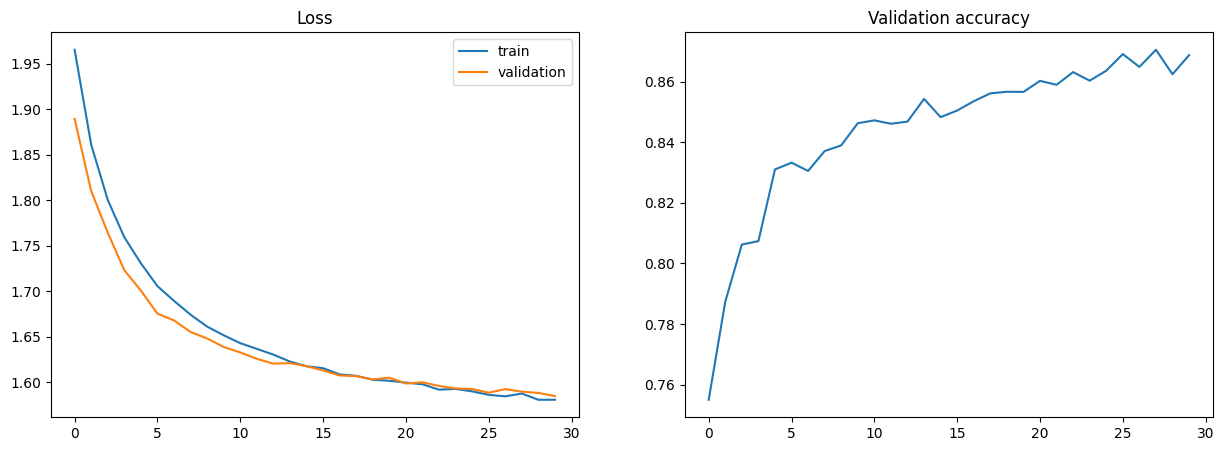

In [42]:
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.BatchNorm1d(500),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(500, 200),
    nn.BatchNorm1d(200),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.BatchNorm1d(10),
    nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 30

train_loss2, val_loss2, val_accuracy2 = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

plot_train_process(train_loss2, val_loss2, val_accuracy2)

### Convolution

Using device: cpu
Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done

Dataset size: 16851, labels: [0 1 2 3 4 5 6 7 8 9]
Training size: 13481
Validation size: 3370
Images shape: torch.Size([32, 1, 28, 28])
Labels shape: torch.Size([32])
Epoch 1 of 30 took 5.986s
	  training loss: 0.861321
	validation loss: 0.509315
	validation accuracy: 0.843
Epoch 2 of 30 took 6.020s
	  training loss: 0.513978
	validation loss: 0.429351
	validation accuracy: 0.870
Epoch 3 of 30 took 6.034s
	  training loss: 0.434957
	validation loss: 0.394340
	validation accuracy: 0.880
Epoch 4 of 30 took 6.043s
	  training loss: 0.409856
	validation loss: 0.371909
	validation accuracy: 0.894
Epoch 5 of 30 took 5.880s
	  training loss: 0.372848
	validation loss: 0.371993
	validation accuracy: 0.891
Epoch 6 of 30 took 6.314

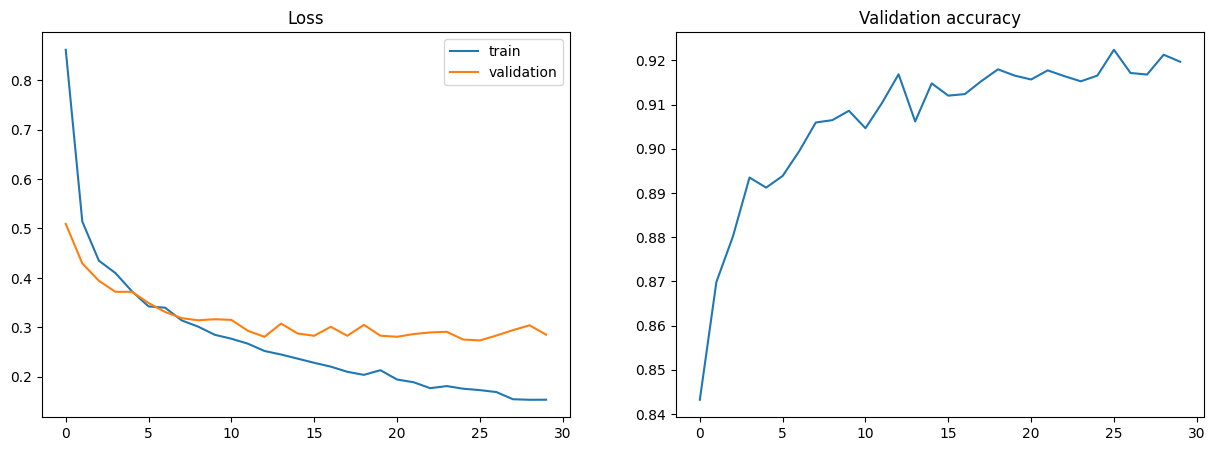

In [46]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Subset
from torchvision import transforms

# Трансформации для данных
transform = transforms.Compose([
    transforms.ToPILImage(),  # Конвертация в PIL Image
    transforms.Resize((28, 28)),  # Изменение размера до 28x28
    transforms.RandomHorizontalFlip(),  # Случайный горизонтальный флип
    transforms.RandomRotation(degrees=15),  # Случайное вращение на 15 градусов
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.Normalize(mean=[0.5], std=[0.5]),  # Нормализация
])

# Определение устройства для вычислений
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Загрузка датасета
dataset = DatasetMNIST('./notMNIST_small', transform=transform)

# Разбиение датасета на подмножества
subset_size = 0.9  # Размер подмножества для тренировки
shrink_indices = subset_ind(dataset, subset_size)
dataset = Subset(dataset, shrink_indices)

# Вывод информации о датасете
print(f'\nDataset size: {len(dataset)}, labels: {np.unique(dataset.dataset.labels)}')

# Разделение на тренировочные и валидационные данные
val_size = 0.2  # Размер валидационной выборки
val_indices = subset_ind(dataset, val_size)

train_indices = [i for i in range(len(dataset)) if i not in val_indices]
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

print(f'Training size: {len(train_dataset)}\nValidation size: {len(val_dataset)}')

# Загрузчики данных
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Просмотр размера данных в батче
train_iter = iter(train_loader)
images, labels = next(train_iter)
print(f'Images shape: {images.size()}\nLabels shape: {labels.size()}')

# Определение модели
model = nn.Sequential(
    # Сверточные слои
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    # Полносвязные слои
    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 500),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(200, 10),  # 10 классов
)

# Перемещение модели на выбранное устройство
model.to(device)

# Оптимизатор и функция потерь
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

# Тренировка модели
n_epochs = 30
train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, optimizer, n_epochs)

plot_train_process(train_loss, val_loss, val_accuracy)



### Plots

In [47]:
import matplotlib.pyplot as plt

def plot_train_process_single(results):
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))  # 2 графика: один под другим

    colors = ['blue', 'green', 'red', 'orange', 'black']

    for model, color in zip(results, colors):
        result = results[model]
        axes[0].plot(result[0], label=f'{model} train loss', color=color, linestyle='-')
        axes[0].plot(result[1], label=f'{model} val loss', color=color, linestyle='--')

    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    axes[0].grid(True)

    for model, color in zip(results, colors):
        result = results[model]
        axes[1].plot(result[2], label=f'{model} val accuracy', color=color, linestyle='-')

    axes[1].set_title('Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

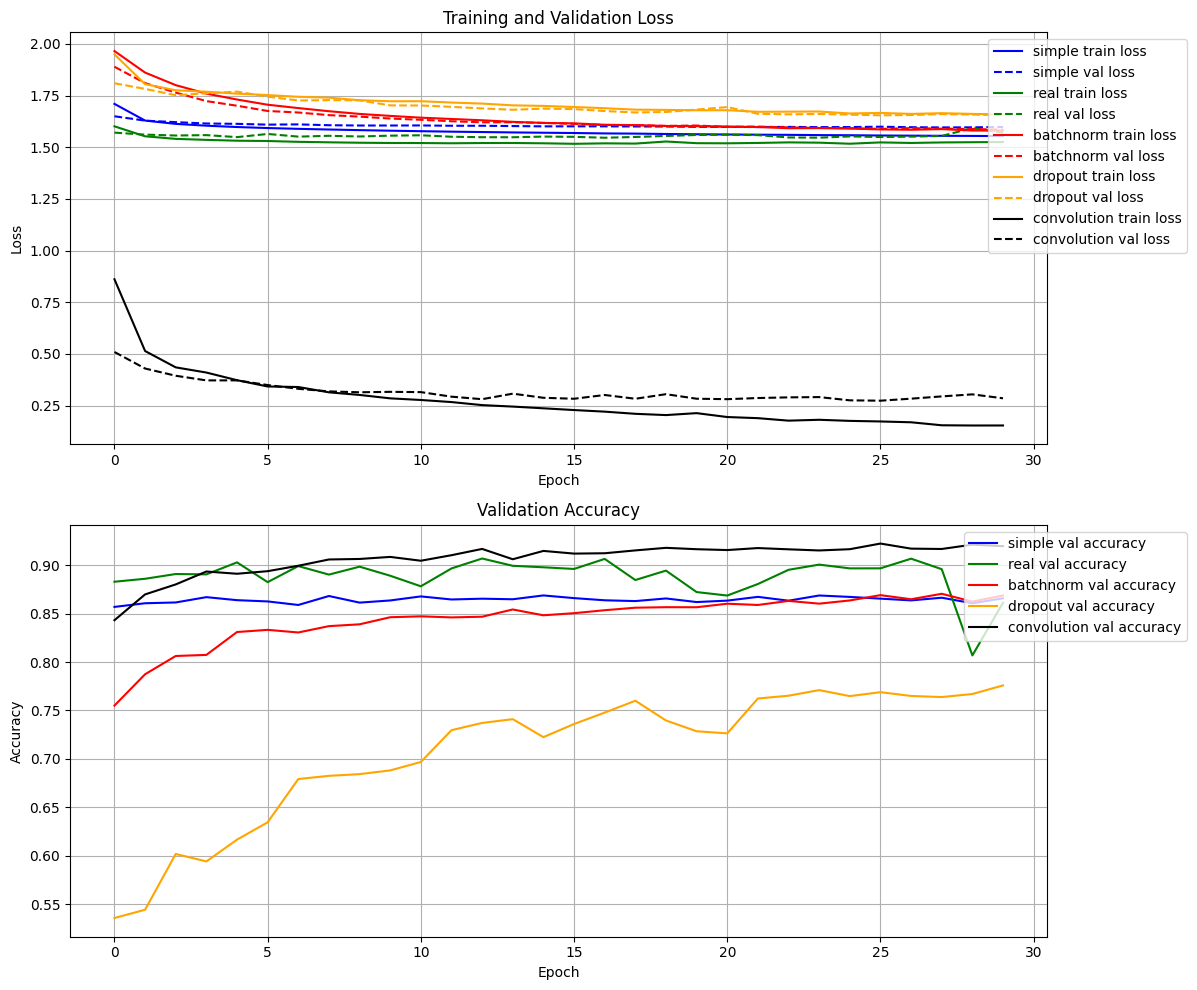

In [48]:
results = {
    'simple': (simple_train_loss, simple_val_loss, simple_val_accuracy),
    'real': (real_train_loss, real_val_loss, real_val_accuracy),
    'batchnorm': (train_loss2, val_loss2, val_accuracy2),
    'dropout': (train_loss1, val_loss1, val_accuracy1),
    'convolution': (train_loss, val_loss, val_accuracy),
}

plot_train_process_single(results)

### 3. Save the model (model checkpointing)

Now we have trained a model! Obviously we do not want to retrain the model everytime we want to use it. Plus if you are training a super big model, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened or you simply want to test models at different training iterations.

Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk

In [ ]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)

def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [ ]:
# create a brand new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Testing -- you should get a pretty poor performance since the model hasn't learned anything yet.
test()

#### Define a training loop with model checkpointing

In [ ]:
def train_save(epoch, save_interval, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            # different from before: saving model checkpoints
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)
            iteration += 1
        test()

    # save the final model
    save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)

In [ ]:
train_save(5, save_interval=500, log_interval=100)

In [ ]:
!ls mnist*.pth

In [ ]:
# create a new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# load from the final checkpoint
load_checkpoint('<CHECKPOINT NAME>', model, optimizer)
# should give you the final model accuracy
test()

### More about pytorch:
* Using torch on GPU and multi-GPU - [link](http://pytorch.org/docs/master/notes/cuda.html)
* More tutorials on pytorch - [link](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* Pytorch examples - a repo that implements many cool DL models in pytorch - [link](https://github.com/pytorch/examples)
* Practical pytorch - a repo that implements some... other cool DL models... yes, in pytorch - [link](https://github.com/spro/practical-pytorch)
* And some more - [link](https://www.reddit.com/r/pytorch/comments/6z0yeo/pytorch_and_pytorch_tricks_for_kaggle/)